In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Modelling
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [14]:
# Data handling
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Saving model
import joblib


In [4]:
df = pd.read_csv('data\cleaned_data.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low_Fat,0.016047,Food,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Drink,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low_Fat,0.016760,Food,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Food,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Non_Edible,0.000000,Non_Consumables,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
X = df.drop("Item_Outlet_Sales", axis=1)
y = df["Item_Outlet_Sales"]


In [7]:
print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (8523, 11)
Target shape: (8523,)


In [8]:
y


0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [9]:
categorical_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type',
                    'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

numerical_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (6818, 11)
Testing set: (1705, 11)


In [15]:
# Define preprocessing steps
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])


In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=200),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}


In [17]:
results = []

for name, model in models.items():
    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    
    # Evaluate
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    results.append({
        'Model': name,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })
    
    print(f"✅ {name} trained successfully.")


✅ Linear Regression trained successfully.
✅ Ridge Regression trained successfully.
✅ Lasso Regression trained successfully.
✅ Random Forest trained successfully.
✅ Gradient Boosting trained successfully.
✅ XGBoost trained successfully.
✅ CatBoost trained successfully.


In [18]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2 Score', ascending=False)
results_df.reset_index(drop=True, inplace=True)

print("\n📊 Model Performance Comparison:")
display(results_df)



📊 Model Performance Comparison:


,Model,R2 Score,MAE,RMSE
0,Gradient Boosting,0.602344,730.002681,1039.623051
1,CatBoost,0.588295,738.984917,1057.829357
2,Random Forest,0.560304,761.152576,1093.196937
3,XGBoost,0.541883,767.788578,1115.862277
4,Ridge Regression,0.485718,878.013170,1182.286932
5,Lasso Regression,0.415700,932.495427,1260.202060
6,Linear Regression,0.402991,944.832743,1273.833954


In [19]:
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Performing Model: {best_model_name}")

# Re-train the best model on full dataset
best_model = models[best_model_name]
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

final_pipeline.fit(X, y)

# # Save model
# joblib.dump(final_pipeline, f"{best_model_name.replace(' ', '_')}_Model.joblib")

# print(f"✅ Model saved as: {best_model_name.replace(' ', '_')}_Model.joblib")



🏆 Best Performing Model: Gradient Boosting


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Item_Weight',
                                                   'Item_Visibility',
                                                   'Item_MRP',
                                                   'Outlet_Establishment_Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Item_Identifier',
                                                   'Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Identifier',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

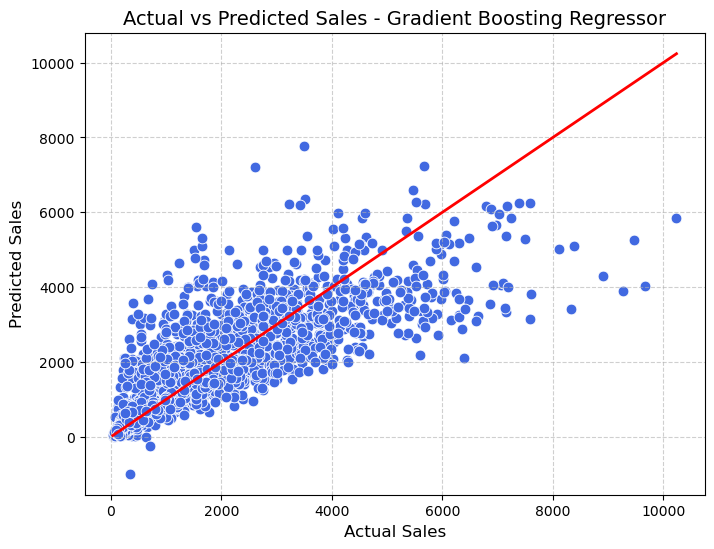

In [22]:
# Create a comparison DataFrame
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison, color='royalblue', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # reference line
plt.title("Actual vs Predicted Sales - Gradient Boosting Regressor", fontsize=14)
plt.xlabel("Actual Sales", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

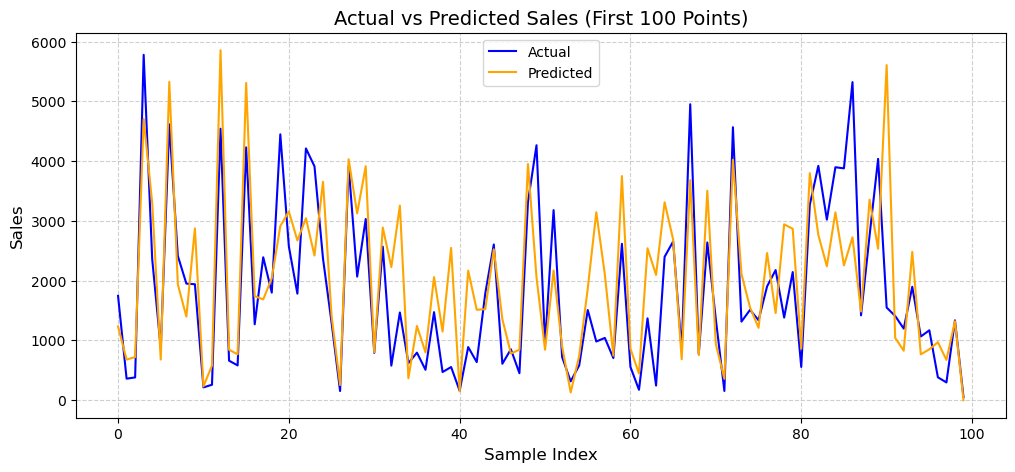

In [25]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='orange')
plt.title("Actual vs Predicted Sales (First 100 Points)", fontsize=14)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [26]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
7503,1743.0644,1230.797825,512.266575
2957,356.8688,676.616950,-319.748150
7031,377.5086,717.999644,-340.491044
1084,5778.4782,4704.915683,1073.562517
856,2356.9320,3295.243931,-938.311931
...,...,...,...
7205,3004.0896,1712.406267,1291.683333
3257,890.8404,2141.699336,-1250.858936
6346,629.1810,697.407519,-68.226519
6318,253.0040,642.702278,-389.698278


In [ ]:
import joblib

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print("✅ Model saved as 'best_model.pkl'")
